In [586]:
# ============= SET-UP =====================
# --- Standard library ---
import sys  # System pathing
from copy import deepcopy

# --- Scientific ---
import numpy as np  # General computational tools
from sklearn import metrics, decomposition  # Measuring classifier performance
from scipy.special import comb

# --- Network science ---
import networkx as nx  # General network tools
from node2vec import Node2Vec as N2V  # Embedding tools

# --- Project source code ---
sys.path.append("../src/")
from Utils import *  # Custom synthetic benchmarks
from glee import eigenmaps

# --- Data handling and visualization ---
import matplotlib.pyplot as plt

# --- Miscellaneous ---
accuracy = metrics.accuracy_score
auroc = metrics.roc_auc_score
PCA = decomposition.PCA

In [587]:
# Process parameters
N = 500
tau1 = 2.1
tau2 = 1.0
mu = 0.1
min_community = 100
average_degree = 5
max_degree = np.sqrt(N)
prob_relabel = 1.0

pfi = 0.5

largest_component = True

dimensions = 128

# Form "raw" duplex
D, _sigma1, _sigma2, _mu_temp = lfr_multiplex(N, tau1, tau2, mu, average_degree, max_degree, min_community, prob_relabel)

# Split into layers
G, H = duplex_network(D, 1, 2)

# Observe partial information
R_G, R_H, testset = partial_information(G, H, pfi)

# Restrict to largest connected component (if specified)
if largest_component:
    R_G_ = nx.Graph()
    R_H_ = nx.Graph()
    # nodes = set(R_G.nodes()) | set(R_H.nodes())
    # nodes = sorted(list(nodes))
    R_G_.add_node(N)
    R_H_.add_node(N)

    maxcc_R_G = max(nx.connected_components(R_G), key=len)
    maxcc_R_H = max(nx.connected_components(R_H), key=len)

    edges_R_G_ = set(R_G.subgraph(maxcc_R_G).edges())
    edges_R_H_ = set(R_H.subgraph(maxcc_R_H).edges())
    R_G_.add_edges_from(edges_R_G_)
    R_H_.add_edges_from(edges_R_H_)

    testset = {
        edge: gt_
        for edge, gt_ in testset.items()
        if edge in edges_R_G_ & edges_R_H_
    }
else:
    R_G_ = R_G
    R_H_ = R_H

setting... -N 500
setting... -mu 0.1
setting... -maxk 22.360679774997898
setting... -k 5
setting... -t1 2.1
setting... -t2 1.0

**************************************************************
number of nodes:	500
average degree:	5
maximum degree:	22
exponent for the degree distribution:	2.1
exponent for the community size distribution:	1
mixing parameter:	0.1
number of overlapping nodes:	0
number of memberships of the overlapping nodes:	0
**************************************************************

-----------------------------------------------------------
community size range automatically set equal to [3 , 22]
building communities... 
connecting communities... 
recording network...


---------------------------------------------------------------------------
network of 500 vertices and 1038 edges;	 average degree = 4.152

average mixing parameter: 0.112765 +/- 0.174117
p_in: 0.464045	p_out: 0.000792563


Segmentation fault (core dumped)


In [588]:
c = set(R_G_.edges()) & set(R_H_.edges())
R_G_cut_c = set(R_G_.edges()) - c
R_H_cut_c = set(R_H_.edges()) - c

print(
    len(c & set(testset.keys())) / len(set(testset.keys())),
    len(R_G_cut_c)/len(set(R_G_.edges())),
    len(R_H_cut_c)/len(set(R_H_.edges()))
)

0.4540682414698163 0.4822923374114617 0.47724317295188556


In [589]:
embedding = "n2v"

if embedding == "glee" or embedding == "eigen":
    E_alpha, eigen_alpha = eigenmaps(R_G_, dimensions, method=embedding, return_vals=True)
    E_beta, eigen_beta = eigenmaps(R_H_, dimensions, method=embedding, return_vals=True)
elif embedding == "n2v":
    E_alpha = N2V(R_G_, dimensions=dimensions, walk_length=30, num_walks=100, workers=4, quiet=True).fit(window=10, min_count=1, batch_words=4).wv
    E_beta = N2V(R_H_, dimensions=dimensions, walk_length=30, num_walks=100, workers=4, quiet=True).fit(window=10, min_count=1, batch_words=4).wv
    E_alpha = {
        int(E_alpha.index_to_key[i]) : E_alpha.vectors[i]
        for i in range(G.number_of_nodes())
    }
    E_beta = {
        int(E_beta.index_to_key[i]) : E_beta.vectors[i]
        for i in range(H.number_of_nodes())
    }

In [590]:
pca = PCA(n_components=2)
E_alpha_viz = pca.fit_transform(list(E_alpha.values()))

pca = PCA(n_components=2)
E_beta_viz = pca.fit_transform(list(E_beta.values()))

In [594]:
def reconstruct_system(testset, G, H, G_, H_, metric="negexp"):
    cls = []
    scores = []
    gt = []

    for edge, gt_ in testset.items():
        i, j = edge
        gt.append(gt_)

        v_G_i = G_[i]
        v_G_j = G_[j]
        v_H_i = H_[i]
        v_H_j = H_[j]

        d_G = np.linalg.norm(v_G_i - v_G_j)
        d_H = np.linalg.norm(v_H_i - v_H_j)

        # * Thresholding to avoid inactive nodes, embedded at origin, having incorrect placements
        if d_G <= 1e-12:
            d_G = sys.maxsize
        if d_H <= 1e-12:
            d_H = sys.maxsize

        if metric == "inverse":
            d_G = 1 / d_G
            d_H = 1 / d_H
        elif metric == "negexp":
            d_G = np.exp(-d_G)
            d_H = np.exp(-d_H)

        t_G = d_G / (d_G + d_H)
        t_H = 1 - t_G

        scores.append(t_G)

        cls_ = np.random.randint(2)
        if t_G != t_H:
            if np.random.rand() <= t_G:
                cls_ = 1
            else:
                cls_ = 0
        cls.append(cls_)

    return cls, scores, gt

def measure_performance(cls, scores, gt):
    acc = accuracy(gt, cls)
    auc = auroc(gt, scores)

    return acc, auc

In [595]:
cls, scores, gt = reconstruct_system(testset, G, H, E_alpha, E_beta, "inverse")
acc, auc = measure_performance(cls, scores, gt)
print(f"Accuracy: {acc:.4f}, AUROC: {auc:.4f}")

Accuracy: 0.5525, AUROC: 0.8543


Text(0.5, 1.0, "'Big' Picture")

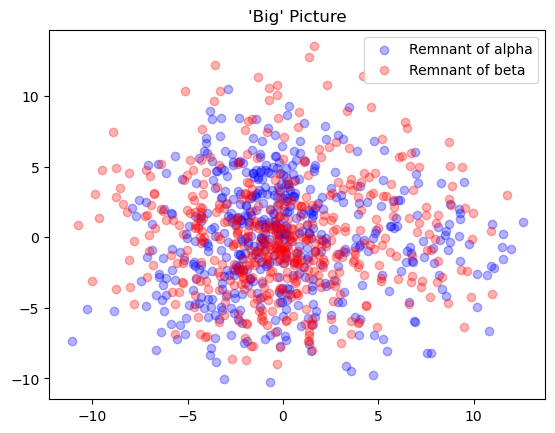

In [599]:
plt.figure()
plt.scatter(
    x=[v[0] for v in E_alpha_viz],
    y=[v[1] for v in E_alpha_viz],
    color="blue",
    label="Remnant of alpha",
    alpha=0.3
)
plt.scatter(
    x=[v[0] for v in E_beta_viz],
    y=[v[1] for v in E_beta_viz],
    color="red",
    label="Remnant of beta",
    alpha=0.3
)
plt.legend()
plt.title("'Big' Picture")

Text(0.5, 1.0, 'Difference of incident node vectors\nExample edge: (487, 102) (28)')

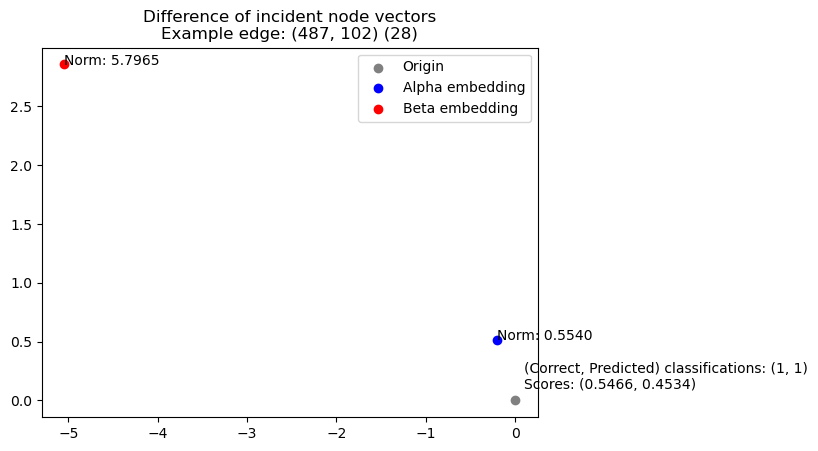

In [600]:
# --- Examine a particular edge's node embeddings ---
# Retrieve a particular example from test set by index
example_idx = np.random.randint(0, len(testset))
example = list(testset.keys())[example_idx]
i, j = example

# Retrieve reconstruction information
correct_layer = testset[example]
predicted_layer = cls[example_idx]

# Some notation convenience
x_alpha = E_alpha[i][0]-E_alpha[j][0]
y_alpha = E_alpha[i][1]-E_alpha[j][1]
x_beta = E_beta[i][0]-E_beta[j][0]
y_beta = E_beta[i][1]-E_beta[j][1]
vector_alpha = (x_alpha, y_alpha)
vector_beta = (x_beta, y_beta)

# Plot information
fig, ax = plt.subplots()
plt.scatter(x=0, y=0, color="gray", label="Origin")
ax.annotate(f"(Correct, Predicted) classifications: ({correct_layer}, {predicted_layer})\nScores: ({scores[example_idx]:.4f}, {1-scores[example_idx]:.4f})", xy=(0.1,0.1))

# Alpha embedding
plt.scatter(x=x_alpha, y=y_alpha, color="blue", label="Alpha embedding")
ax.annotate(f"Norm: {np.linalg.norm(vector_alpha):.4f}", xy=vector_alpha)

# Beta embedding
plt.scatter(x=x_beta, y=y_beta, color="red", label="Beta embedding")
ax.annotate(f"Norm: {np.linalg.norm(vector_beta):.4f}", xy=vector_beta)

plt.legend()
plt.title(f"Difference of incident node vectors\nExample edge: {example} ({example_idx})")

Text(0.5, 1.0, 'Test set with beta ground truth\nDifference vectors')

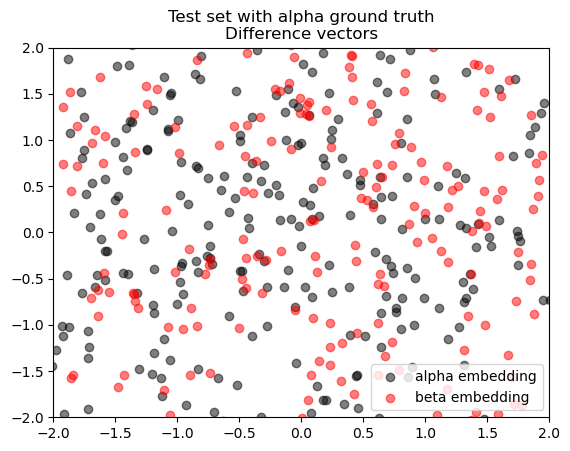

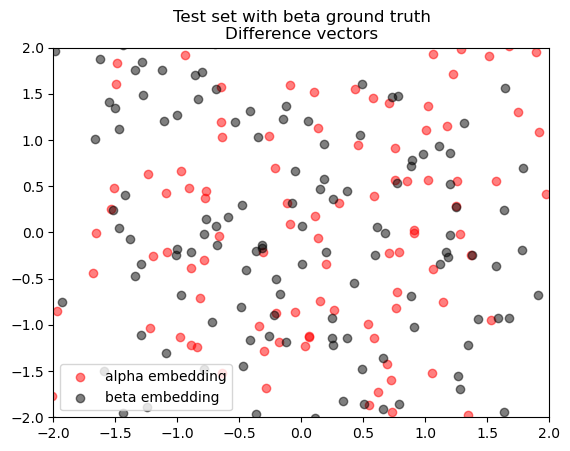

In [601]:
plot_lims = 2

edges_gt_alpha = [
    edge
    for edge, gt in testset.items() if gt == 1
]
edges_gt_beta = [
    edge
    for edge, gt in testset.items() if gt == 0
]


# Test edges that belong to alpha
plt.figure()
plt.scatter(
    x=[E_alpha[i][0] - E_alpha[j][0] for (i,j) in edges_gt_alpha],
    y=[E_alpha[i][1] - E_alpha[j][1] for (i,j) in edges_gt_alpha],
    color="black",
    label="alpha embedding",
    alpha=0.5
)
plt.scatter(
    x=[E_beta[i][0] - E_beta[j][0] for (i,j) in edges_gt_alpha],
    y=[E_beta[i][1] - E_beta[j][1] for (i,j) in edges_gt_alpha],
    color="red",
    label="beta embedding",
    alpha=0.5
)

plt.xlim(-plot_lims,plot_lims)
plt.ylim(-plot_lims,plot_lims)

plt.legend()
plt.title("Test set with alpha ground truth\nDifference vectors")


# ----------------


# Test edges that belong to alpha
plt.figure()
plt.scatter(
    x=[E_alpha[i][0] - E_alpha[j][0] for (i,j) in edges_gt_beta],
    y=[E_alpha[i][1] - E_alpha[j][1] for (i,j) in edges_gt_beta],
    color="red",
    label="alpha embedding",
    alpha=0.5
)
plt.scatter(
    x=[E_beta[i][0] - E_beta[j][0] for (i,j) in edges_gt_beta],
    y=[E_beta[i][1] - E_beta[j][1] for (i,j) in edges_gt_beta],
    color="black",
    label="beta embedding",
    alpha=0.5
)

plt.xlim(-plot_lims,plot_lims)
plt.ylim(-plot_lims,plot_lims)

plt.legend()
plt.title("Test set with beta ground truth\nDifference vectors")


Text(0.5, 1.0, 'Test set with beta embedding\nDifference vectors')

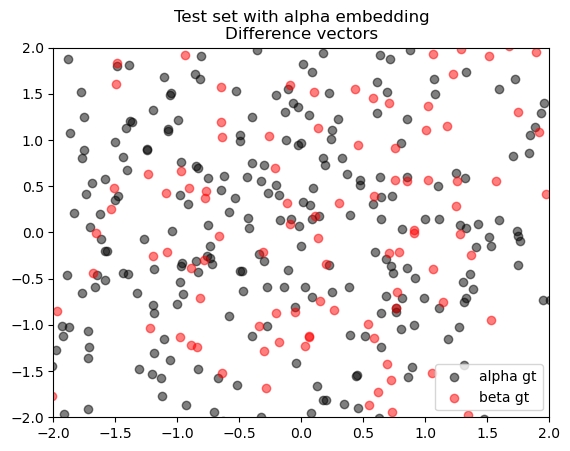

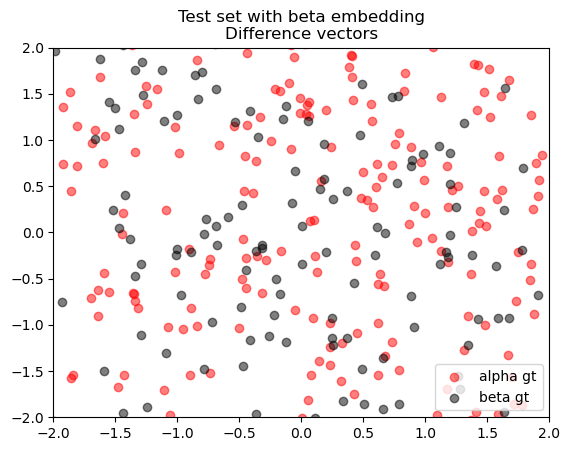

In [602]:
# Test edges under alpha embedding
plt.figure()
plt.scatter(
    x=[E_alpha[i][0] - E_alpha[j][0] for (i,j) in edges_gt_alpha],
    y=[E_alpha[i][1] - E_alpha[j][1] for (i,j) in edges_gt_alpha],
    color="black",
    label="alpha gt",
    alpha=0.5
)
plt.scatter(
    x=[E_alpha[i][0] - E_alpha[j][0] for (i,j) in edges_gt_beta],
    y=[E_alpha[i][1] - E_alpha[j][1] for (i,j) in edges_gt_beta],
    color="red",
    label="beta gt",
    alpha=0.5
)

plt.xlim(-plot_lims,plot_lims)
plt.ylim(-plot_lims,plot_lims)

plt.legend()
plt.title("Test set with alpha embedding\nDifference vectors")


# ----------------


# Test edges under beta embedding
plt.figure()
plt.scatter(
    x=[E_beta[i][0] - E_beta[j][0] for (i,j) in edges_gt_alpha],
    y=[E_beta[i][1] - E_beta[j][1] for (i,j) in edges_gt_alpha],
    color="red",
    label="alpha gt",
    alpha=0.5
)
plt.scatter(
    x=[E_beta[i][0] - E_beta[j][0] for (i,j) in edges_gt_beta],
    y=[E_beta[i][1] - E_beta[j][1] for (i,j) in edges_gt_beta],
    color="black",
    label="beta gt",
    alpha=0.5
)

plt.xlim(-plot_lims,plot_lims)
plt.ylim(-plot_lims,plot_lims)

plt.legend()
plt.title("Test set with beta embedding\nDifference vectors")


In [603]:
deltas_alpha = {edge: None for edge in set(R_G_.edges())}
deltas_beta = {edge: None for edge in set(R_H_.edges())}

for edge in deltas_alpha.keys():
    i, j = edge
    d_alpha = np.linalg.norm(E_alpha[i] - E_alpha[j])
    d_beta = np.linalg.norm(E_beta[i] - E_beta[j])
    deltas_alpha[edge] = (d_alpha, d_beta)

for edge in deltas_beta.keys():
    i, j = edge
    d_alpha = np.linalg.norm(E_alpha[i] - E_alpha[j])
    d_beta = np.linalg.norm(E_beta[i] - E_beta[j])
    deltas_beta[edge] = (d_alpha, d_beta)

deltas = deepcopy(deltas_alpha)
deltas.update(deltas_beta)

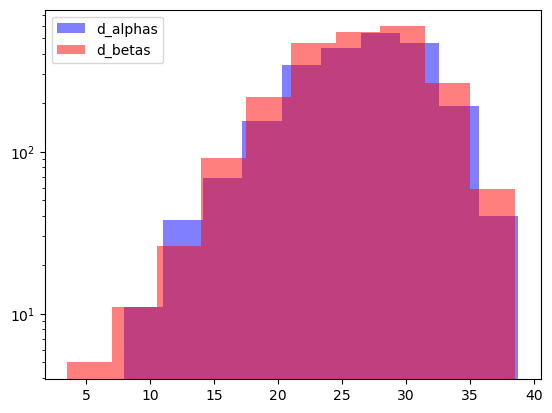

In [604]:
plt.figure()
plt.hist([x[0] for x in deltas.values()], color="blue", label="d_alphas", alpha=0.5)
plt.hist([x[1] for x in deltas.values()], color="red", label="d_betas", alpha=0.5)
plt.yscale("log")
plt.legend()

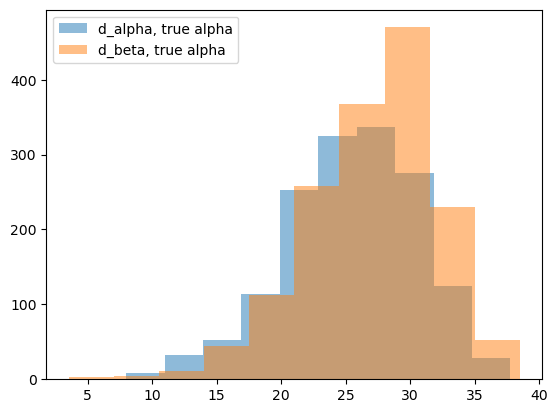

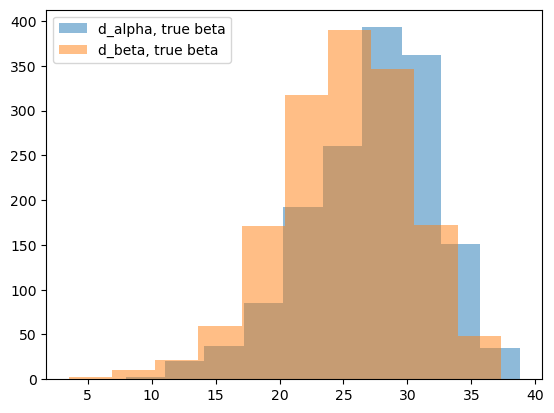

In [605]:
plt.figure()
plt.hist([x[0] for x in deltas_alpha.values()], label="d_alpha, true alpha", alpha=0.5)
plt.hist([x[1] for x in deltas_alpha.values()], label="d_beta, true alpha", alpha=0.5)
plt.legend()

plt.figure()
plt.hist([x[0] for x in deltas_beta.values()], label="d_alpha, true beta", alpha=0.5)
plt.hist([x[1] for x in deltas_beta.values()], label="d_beta, true beta", alpha=0.5)
plt.legend()

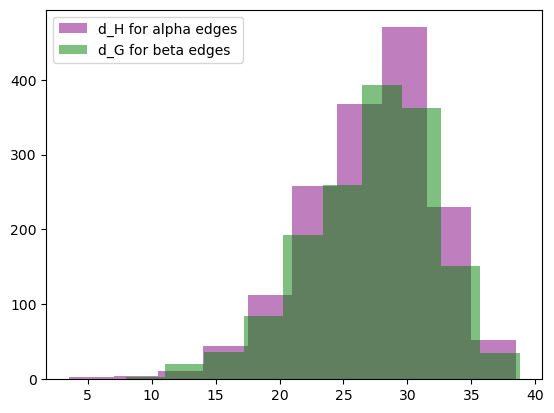

In [606]:
d_a_bad = []
d_b_bad = []


# Within 0 to 99, alpha stays same, beta goes to 100 + i
for edge in R_G_.edges():
    i, j = edge
    _h = np.linalg.norm(E_beta[i] - E_beta[j])
    d_a_bad.append(_h)


# Within 100 to 199, alpha stays same, beta goes to 100 - i
for edge in R_H_.edges():
    i, j = edge
    _g = np.linalg.norm(E_alpha[i] - E_alpha[j])
    d_b_bad.append(_g)

plt.figure()
plt.hist(d_a_bad, color="purple", label="d_H for alpha edges", alpha=0.5)
plt.hist(d_b_bad, color="green", label="d_G for beta edges", alpha=0.5)
plt.legend()